TLDR:
- in this notebook, we evaluate the accuracy of llm-based market resolution
- we collected all the markets after 31-12-2023
- manually answered using perplexity.ai and google search about 100+ questions
- the results shows llm-based market resolution isn't very accurate (accuracy 30%)

In [ ]:
import requests
import pandas as pd
from string import  Template
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from ipywidgets import widgets, Button, VBox, HBox, Label
from IPython.display import display

### Collecting fpmm market data

In [2]:
INVALID_ANSWER = "0xffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff"
YES_ANSWER = "0x0000000000000000000000000000000000000000000000000000000000000000"
NO_ANSWER = "0x0000000000000000000000000000000000000000000000000000000000000001"
URL = "https://api.thegraph.com/subgraphs/name/protofire/omen-xdai"
CREATOR = "0x89c5cc945dd550BcFfb72Fe42BfF002429F46Fec"
BATCH_SIZE = 1000

FPMMS_QUERY = Template(
    """
    {
      fixedProductMarketMakers(
        where: {
          creator: "${creator}",
          id_gt: "${fpmm_id}",
          isPendingArbitration: false
        },
        orderBy: id,
        first: ${first}
      ){
        id
        currentAnswer
        question {
          outcomes
        }
        title
        creationTimestamp
      }
    }
    """
)

def fetch_data():
    fpmm_id = 0
    markets = []
    while True:
        query = FPMMS_QUERY.substitute(creator=CREATOR, fpmm_id=fpmm_id, first=BATCH_SIZE)
        data = requests.post(URL, json={'query': query}).json()
        fpmm_data = data['data']['fixedProductMarketMakers']
        if not fpmm_data:
            break
        markets.extend(fpmm_data)
        fpmm_id = fpmm_data[-1]['id']
    return markets

In [3]:
# fetch the data
markets = fetch_data()

# convert the data to a dataframe
df = pd.DataFrame(markets)
print(df.shape)

# convert the timestamp to datetime
df['datetime'] = pd.to_datetime(df['creationTimestamp'], unit='s')

# select only the rows in 2024
df = df[df['datetime'].dt.year == 2024].reset_index(drop=True)
print(df.shape)

# remove currentAnswer == None
df = df[df['currentAnswer'].notna()].reset_index(drop=True)
print(df.shape)

(2184, 5)
(564, 6)
(479, 6)


In [4]:
df['currentAnswer'].replace(INVALID_ANSWER, -1, inplace=True)
df['currentAnswer'].replace(YES_ANSWER, 0, inplace=True)
df['currentAnswer'].replace(NO_ANSWER, 1, inplace=True)

df['currentAnswer'].value_counts()

 0    362
 1    116
-1      1
Name: currentAnswer, dtype: int64

In [5]:
def current_answer_to_answer(row):
    if row['currentAnswer'] == -1:
        return 'invalid'
    elif row['currentAnswer'] == 0:
        return 'yes'
    elif row['currentAnswer'] == 1:
        return 'no'
    else:
        return 'unknown'
    
df['answer'] = df.apply(current_answer_to_answer, axis=1)

In [6]:
class EnhancedDataFrameRowWidget:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.current_index = 0  # Start with the first row
        self.init_ui()
        
    def init_ui(self):
        # Display area for the DataFrame row
        self.row_display = VBox([])
        
        # Next and Previous buttons for navigation
        self.next_button = Button(description="Next", button_style='primary')
        self.prev_button = Button(description="Previous", button_style='primary')
        
        # Event handlers for buttons
        self.next_button.on_click(self.next_row)
        self.prev_button.on_click(self.prev_row)
        
        # Dropdown for human_answer
        self.human_answer_dropdown = widgets.Dropdown(
            options=['yes', 'no', 'invalid'],
            value=None,
            description='Human Answer:',
            disabled=False,
        )
        
        # Confirm button to update the 'human_answer'
        self.confirm_button = Button(description="Confirm", button_style='success')
        self.confirm_button.on_click(self.update_human_answer)
        
        # Organizing the layout
        navigation_controls = HBox([self.prev_button, self.next_button])
        self.controls = VBox([navigation_controls, self.human_answer_dropdown, self.confirm_button])
        
        # Main widget box
        self.box = VBox([self.row_display, self.controls])
        display(self.box)
        
        # Initialize the display with the first row
        self.update_display()
        
    def update_display(self):
        # Update displayed row information
        self.row_display.children = [
            Label(f'{key}: {value}') for key, value in self.dataframe.iloc[self.current_index].items()
        ]
        # Reset human_answer_dropdown to None for new row
        self.human_answer_dropdown.value = None
        
    def next_row(self, b):
        # Move to the next row if not at the end
        if self.current_index < len(self.dataframe) - 1:
            self.current_index += 1
            self.update_display()
            
    def prev_row(self, b):
        # Move to the previous row if not at the beginning
        if self.current_index > 0:
            self.current_index -= 1
            self.update_display()
            
    def update_human_answer(self, b):
        # Update the dataframe with the human_answer
        self.dataframe.at[self.current_index, 'human_answer'] = self.human_answer_dropdown.value
        print(f"Human answer for row {self.current_index} updated to: {self.dataframe.at[self.current_index, 'human_answer']}")


In [7]:
# data_row_widget = EnhancedDataFrameRowWidget(df)

Human answer for row 0 updated to: yes
Human answer for row 1 updated to: yes
Human answer for row 2 updated to: no
Human answer for row 3 updated to: yes
Human answer for row 4 updated to: no
Human answer for row 5 updated to: no
Human answer for row 6 updated to: no
Human answer for row 7 updated to: yes
Human answer for row 8 updated to: yes
Human answer for row 9 updated to: yes
Human answer for row 10 updated to: yes
Human answer for row 11 updated to: yes
Human answer for row 12 updated to: yes
Human answer for row 13 updated to: no
Human answer for row 14 updated to: yes
Human answer for row 15 updated to: yes
Human answer for row 16 updated to: no
Human answer for row 17 updated to: no
Human answer for row 19 updated to: no
Human answer for row 20 updated to: no
Human answer for row 21 updated to: no
Human answer for row 22 updated to: no
Human answer for row 23 updated to: yes
Human answer for row 24 updated to: no
Human answer for row 25 updated to: yes
Human answer for row 2

In [20]:
df.to_csv("../gt_eval.csv", index=False)

### Evaluating the data

In [4]:
df = pd.read_csv("../gt_eval.csv")

In [5]:
df['human_answer'].value_counts()

no         66
yes        44
invalid     9
Name: human_answer, dtype: int64

In [7]:
# value count of mech answer
# there is a tendency for the model to predict 'yes' more often
print(df['answer'].value_counts())
print()
print(df['answer'].value_counts() / len(df))


yes        362
no         116
invalid      1
Name: answer, dtype: int64

yes        0.755741
no         0.242171
invalid    0.002088
Name: answer, dtype: float64


In [8]:
# selct only the rows with human_answer
df_human = df[df['human_answer'].notna()].reset_index(drop=True)

# remove invalid answers
df_human = df_human[df_human['human_answer'] != 'invalid'].reset_index(drop=True)

In [9]:
print(df_human['answer'].value_counts())
print()
print(df_human['answer'].value_counts() / len(df_human))

yes    80
no     30
Name: answer, dtype: int64

yes    0.727273
no     0.272727
Name: answer, dtype: float64


In [44]:
# value count of human answer
print(df_human['human_answer'].value_counts())
print()
print(df_human['human_answer'].value_counts() / len(df_human))

no     66
yes    44
Name: human_answer, dtype: int64

no     0.6
yes    0.4
Name: human_answer, dtype: float64


In [11]:
preds = df_human['answer'].values
labels = df_human['human_answer'].values

Text(50.722222222222214, 0.5, 'True')

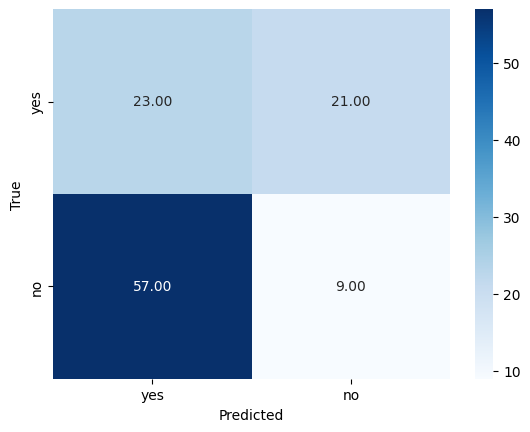

In [13]:
# confusion matrix for human answer vs mech answer. sklearn is used to calculate the confusion matrix
# the results shows poor performance of the model
cm = confusion_matrix(labels, preds, labels=['yes', 'no'])
cm = cm
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=['yes', 'no'], yticklabels=['yes', 'no'])
plt.xlabel('Predicted')
plt.ylabel('True')

In [14]:
# accuracy of the model is poor at only 0.29
accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.29


In [ ]:
# what is the precision and recall for the 'no' class? 
# Precision is the number of true positives divided by the number of true positives plus the number of false positives. 
# Recall is the number of true positives divided by the number of true positives plus the number of false negatives.

In [16]:
# Low precision and recall
precision = cm[0,0] / (cm[0,0] + cm[1,0])
print(f"Precision: {precision:.2f}")

Precision: 0.29


In [17]:
recall = cm[0,0] / (cm[0,0] + cm[0,1])
print(f"Recall: {recall:.2f}")

Recall: 0.52


In [18]:
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score:.2f}")

F1 Score: 0.37
